### Goal: 
Use Kmeans to put the birds into two groups, temperature when leaving where they migrate to, and temperature when leaving to go back home

In [1]:
import pandas as pd
import time
import pandas as pd
import requests
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
import random
from matplotlib.patches import Patch
from mpl_toolkits.basemap import Basemap

### Data Preprocessing 

In [2]:
migration_df = pd.read_csv('migrationTimingSiteUse_2008_2015/marbledGodwit_migration_ugashik_ruthrauff.csv')
migration_df.head(3)

,Sort_Order,Animal_ID,Year,Season,Departure_UTC,Arrival_UTC,Departure_Local,Arrival_Local,Flight_Duration_Hours,Stage,Overall_Duration_Days,Final_Destination,Departure_Site,Arrival_Site,Stay_Duration_Hours
0,1,MAGO_1A,2008,fall,8/7/2008 3:31,8/9/2008 14:53,8/6/2008 18:31,8/9/2008 6:53,59.36,S1,2.47,Y,ugashik,willapa,NaN
1,2,MAGO_2A,2008,fall,7/20/2008 2:17,7/22/2008 4:37,7/19/2008 17:17,7/21/2008 20:37,50.33,S1,2.10,Y,ugashik,bodega,6854.67
2,3,MAGO_2A,2009,spring,5/3/2009 19:17,5/6/2009 0:19,5/3/2009 11:17,5/5/2009 15:19,53.02,N1,NaN,N,bodega,controller,58.99


In [3]:
# Filter the dataframe to only store data if the flight stage is S1 or N1 (the bird is leaving)
filtered_migration_df = migration_df[(migration_df['Stage'] == 'S1') | (migration_df['Stage'] == 'N1')].loc[:, ['Departure_UTC', 'Departure_Site']].reset_index()
filtered_migration_df.head(3)

,index,Departure_UTC,Departure_Site
0,0,8/7/2008 3:31,ugashik
1,1,7/20/2008 2:17,ugashik
2,2,5/3/2009 19:17,bodega


In [4]:
# Get latitude and longitude of deperature sites (from google)
deperature_lat_lon = {
    'ugashik': (57.5577, 157.6269),
    'bodega': (38.3332, 23.0481),
    'humboldt': (40.7195, 124.2426), 
    'moss': (36.8058, 121.7902),
    'bolinas_ocean': (37.8965, 122.6786)
}

In [5]:
# Map the deperature side to its matching latitude and longitude 
filtered_migration_df['Departure_Latitude'] = filtered_migration_df['Departure_Site'].map(lambda x: deperature_lat_lon[x][0])
filtered_migration_df['Departure_Longitude'] = filtered_migration_df['Departure_Site'].map(lambda x: deperature_lat_lon[x][1])
filtered_migration_df.head(3)

,index,Departure_UTC,Departure_Site,Departure_Latitude,Departure_Longitude
0,0,8/7/2008 3:31,ugashik,57.5577,157.6269
1,1,7/20/2008 2:17,ugashik,57.5577,157.6269
2,2,5/3/2009 19:17,bodega,38.3332,23.0481


In [6]:
# Convert the deperature time to UTC
filtered_migration_df['Departure_UTC'] = pd.to_datetime(filtered_migration_df['Departure_UTC'])
filtered_migration_df.head(3)

,index,Departure_UTC,Departure_Site,Departure_Latitude,Departure_Longitude
0,0,2008-08-07 03:31:00,ugashik,57.5577,157.6269
1,1,2008-07-20 02:17:00,ugashik,57.5577,157.6269
2,2,2009-05-03 19:17:00,bodega,38.3332,23.0481


API code from: https://rapidapi.com/meteostat/api/meteostat/

**PLEASE only run me once**

In [7]:
# Function to get average temperature for a given location and date range
def get_temperature_data(lat, lon, start_date, end_date):
    # API url
    url = "https://meteostat.p.rapidapi.com/point/daily"

    querystring = {
        "lat": lat,
        "lon": lon,
        "start": start_date,
        "end": end_date
    }

    headers = {
        'X-RapidAPI-Key': "dce607584dmsh5c8a13db16ffb10p1ada3djsnd4ed56a6987e",
        'X-RapidAPI-Host': "meteostat.p.rapidapi.com"
    }

    try: 
        # API call
        response = requests.get(url, headers=headers, params=querystring)
        data = response.json()['data']
        return data

    except Exception as e:
        print(f"Error: {e}")
        return None

In [8]:
# Get the temperature data
temp_data = []

# Iterate through each row 
for i, row in filtered_migration_df.iterrows():
    # Add row data
    lat = row['Departure_Latitude']
    lon = row['Departure_Longitude']
    start_time = (row['Departure_UTC'] - pd.Timedelta(days=10)).strftime('%Y-%m-%d')
    end_time = (row['Departure_UTC']).strftime('%Y-%m-%d')

    # Call API to get data up to -10 days away
    curr_temp_data = get_temperature_data(lat, lon, start_time, end_time)
    temp_data.append(curr_temp_data)

In [9]:
# Convert temp_data to a pandas data frame
all_data = []
csv_data = []

# Iterate through temp data
for group in temp_data:
    # Store feature data
    feature_data = []
    # Check if data exists
    if group:
        for day in group:
            csv_data.append(day)
            # Check if data exists (again)
            if day['tmin']:
                feature_data.append(day['tmin'])

        feature = sum(feature_data)/len(feature_data)
        all_data.append((day['date'], feature))

# Add 10 day average min to dataframe
temp_df = pd.DataFrame(all_data, columns = ['date', 'average_min'])
temp_df['month'] = pd.to_datetime(temp_df['date']).dt.month

# Convert to csv for safe keeping
df = pd.DataFrame(csv_data)
df.to_csv('temperature_data.csv', index=False)

In [19]:
# Temp dataframe example
temp_df.head(3)

,date,average_min,month
0,2008-08-07,11.981818,8
1,2008-07-20,7.863636,7
2,2009-05-03,10.254545,5


/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 varianc

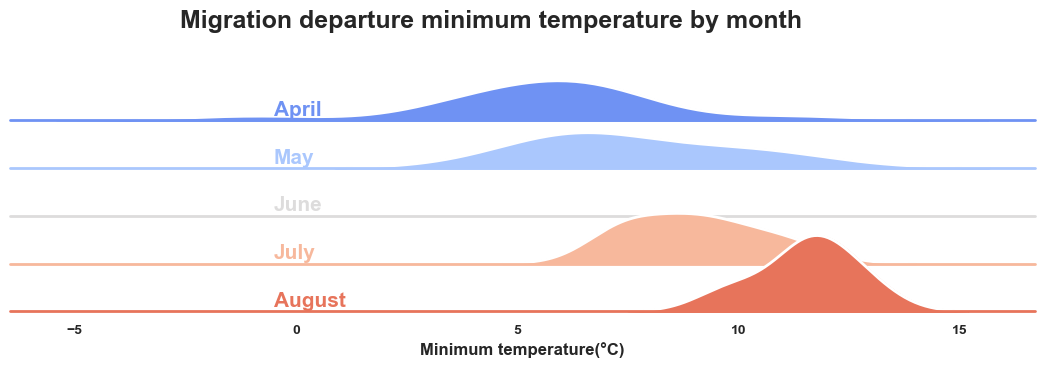

In [11]:
# Source: https://python-graph-gallery.com/ridgeline-graph-seaborn/
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.color_palette(palette='coolwarm', n_colors=5)

# Define dictionaries to make plot pretty
month_dict = {4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August'}

# Plot outline
g = sns.FacetGrid(temp_df, row='month', aspect=15, height=0.75, palette=pal, hue='month')
g.map(sns.kdeplot, 'average_min', bw_adjust=1, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, 'average_min', bw_adjust=1, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Add month names to plot
for i, ax in enumerate(g.axes.flat):
    ax.text(-0.5, 0.02, month_dict[i+4], fontweight='bold', fontsize=15, color=ax.lines[-1].get_color())
g.fig.subplots_adjust(hspace=-0.4)

# Remove ugly titles
g.set_titles("")
g.set(ylabel="")
g.set(yticks=[])
g.despine(bottom=True, left=True)

# Pretty titles
plt.setp(ax.get_xticklabels(), fontsize=10, fontweight='bold')
plt.xlabel('Minimum temperature(°C)', fontweight='bold', fontsize=12)
g.fig.suptitle('Migration departure minimum temperature by month', ha='center', fontsize=18, fontweight='bold')

plt.show()

*done with data preprocessing don't run above anymore!*

### Applying KMeans 

Kmeans code from Homework 3

In [12]:
# Write a function euclidean distance 
def distance(x1, x2):
    return np.sqrt(np.sum((np.array(x1)-np.array(x2))**2))

In [13]:
def kmeans(df, k, tol=0.05): 
    """
    Usage: input 
        df=data frame, 
        k=# of clusters
        tol=tolerance for L_2 convergance check on centroids
    """    
    # Important variables
    columns = ["month", "average_min"]
    prev_error = float('inf')
    
    # Initialize clusters and centroids
    centroid_indexes = random.sample(range(len(df)), k)
    centroids = [tuple(df.iloc[i][columns]) for i in centroid_indexes]
    clusters = [[] for _ in range(k)]
    
    while True:
        # Iterate through every datapoint
        for index, row in df.iterrows():
            row_tuple = tuple(row.loc[columns])
            # Calculate the distance between the row and the centroid
            distances = [distance(row_tuple, centroid) for centroid in centroids]
            # Find the nearest centroid and add it
            nearest_centroid_index = np.argmin(distances)
            clusters[nearest_centroid_index].append(row.loc[columns])

        # Updat the centroids to be the average of the cluster
        new_centroids = [(np.mean([point[0] for point in cluster]),  
                          np.mean([point[1] for point in cluster]))
                         for cluster in clusters]

        # Calculate the error to see if the clustering is complete
        meanerror = np.mean([distance(row, new_centroids[i]) for i, cluster in enumerate(clusters) for row in cluster])
        
        if abs(prev_error - meanerror) <= tol:
            break

        # Update variables
        prev_error = meanerror
        centroids = new_centroids
        clusters = [[] for _ in range(k)]
        
    
    return centroids, clusters, meanerror

In [14]:
# Make gmm dataset and remove outliers
kmeans_df = temp_df[['month', 'average_min']]
kmeans_df = kmeans_df[kmeans_df['month'].isin([4,5]) & (kmeans_df['average_min'] < 7) | kmeans_df['month'].isin([7,8])]
kmeans_df.head(3)

,month,average_min
0,8,11.981818
1,7,7.863636
3,7,7.181818


In [17]:
# Call kmeans
centroids, clusters, mean_error = kmeans(kmeans_df, k=2)

/var/folders/pq/xr8rr6kj661dlbhfxj5vw0z00000gn/T/ipykernel_75207/601754612.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_centroids = [(np.mean([point[0] for point in cluster]),
/var/folders/pq/xr8rr6kj661dlbhfxj5vw0z00000gn/T/ipykernel_75207/601754612.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.mean([point[1] for point in cluster]))
/var/folders/pq/xr8rr6kj661dlbhfxj5vw0z00000gn/T/ipykernel_75207/601754612.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To 

/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/bella/anaconda3/envs/adv_ds_ENV/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na opti

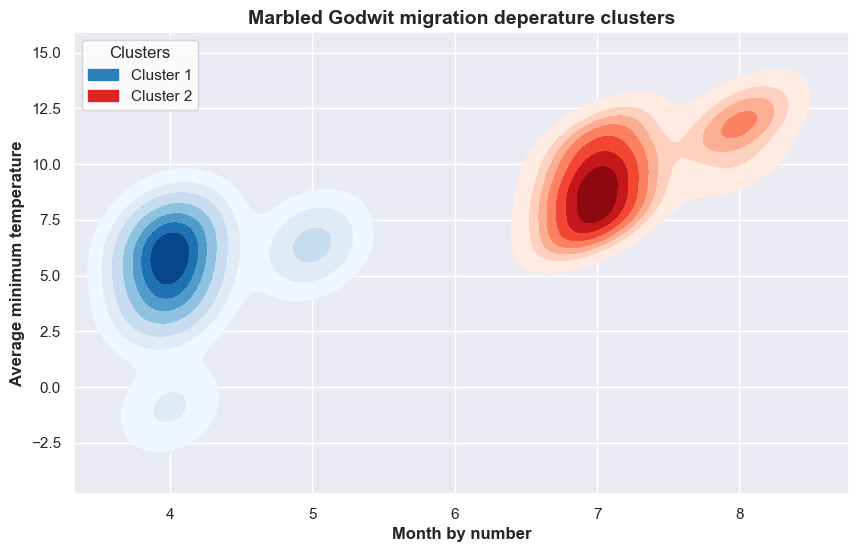

In [18]:
# Reference: https://python-graph-gallery.com/134-how-to-avoid-overplotting-with-python/
# Plot skeleton
sns.set_theme()
fig = plt.figure(figsize=(10,6), facecolor="white")

# Colors
cluster1_palette = sns.color_palette("Blues", as_cmap=True)
cluster2_palette = sns.color_palette("Reds", as_cmap=True)

# Plot KDE for each cluser
sns.kdeplot(data=pd.DataFrame(clusters[0]), x="month", y="average_min", cmap= cluster1_palette, fill=True, levels=8)
sns.kdeplot(data=pd.DataFrame(clusters[1]), x="month", y="average_min", cmap= cluster2_palette, fill=True, levels=8)

# Legend
legend_elements = [
    Patch(facecolor=cluster1_palette(0.7), edgecolor= cluster1_palette(0.7), label='Cluster 1'),
    Patch(facecolor=cluster2_palette(0.7), edgecolor= cluster2_palette(0.7), label='Cluster 2'),
]
legend = plt.legend(handles=legend_elements, loc='upper left', title='Clusters')
legend.get_frame().set_facecolor('white')

# Axis titles
plt.title("Marbled Godwit migration deperature clusters", fontsize=14, fontweight='bold')
plt.xlabel("Month by number", fontweight = 'bold')
plt.ylabel("Average minimum temperature", fontweight = 'bold')
plt.show()